Entender comportamento do cliente é essencial aos negócios, principalmente tratando-se do setor varejista, em que a concorrência é cada vez maior e mais agressiva em criar muito mais do que produtos, mas experiência do usuário.

Nessa análise, a ideia é entender onde há concentração dos clientes consumidores das lojas parceiras Olist, quais são os tipos de produtos mais consumidos, onde encontram-se os detratores e promotores, através de visualizações gráficas com intuito de gerar agilidade na interpretação



In [1]:
import pandas as pd
import folium
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from conf import lendo_dataset

In [2]:
geo = lendo_dataset("geolocation")
customers = lendo_dataset("customers")
order_items = lendo_dataset('order_items')
orders = lendo_dataset("orders")
produtos = lendo_dataset("products")
vendedores = lendo_dataset("sellers")
orders_payments = lendo_dataset("order_payments")
order_review = lendo_dataset("order_reviews")

stop = stopwords.words("portuguese")

In [3]:

cust_geoloc = pd.merge(customers,geo.rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix'}), on='customer_zip_code_prefix').drop_duplicates(subset='customer_unique_id')
loc_clients = cust_geoloc.groupby(['customer_state','customer_city','geolocation_lat','geolocation_lng']).agg({'customer_unique_id':'count'}).reset_index()
Bra = folium.Map(location=[-16.1237611, -59.9219642],
    zoom_start=6)
loc_clients_50=loc_clients.loc[loc_clients['customer_unique_id']>=50] 
colors = {
 'BA': 'pink',
 'ES': 'blue',
 'MG': 'green',
 'RJ': 'orange',
 'RS': 'red',
 'SC': 'purple',
 'SP': 'black'
}
for x, y in loc_clients_50.iterrows():
    folium.Marker(
        location=[y['geolocation_lat'],y['geolocation_lng']],
        popup=f"{y['customer_unique_id']},{y['customer_city']}",
        icon=folium.Icon(color=colors[y['customer_state']])
    ).add_to(Bra)


uf_lat_log = pd.read_csv('./uf_lat_log.csv',delimiter=';')
Bra_Geral = folium.Map(location=[-16.1237611, -59.9219642],zoom_start=6)
geral_v_unica = cust_geoloc.groupby(['customer_state']).agg({'customer_unique_id':'count'}).reset_index()

geral_v_unica = pd.merge(geral_v_unica,uf_lat_log.rename(columns={'uf':'customer_state'}), on='customer_state')

for x, y in geral_v_unica.iterrows():
    folium.Marker(
        location=[y['latitude'],y['longitude']],
        popup=f"{y['customer_unique_id']},{y['customer_state']}",
       
    ).add_to(Bra_Geral)


In [4]:
Bra

In [5]:
Bra_Geral

Categorias mais compradas

In [6]:

customers_orders = pd.merge(order_items,orders[['order_id', 'customer_id']], on='order_id')
customers_orders = customers_orders.merge(customers, on='customer_id')
customers_prod = customers_orders.merge(produtos,on='product_id')
prod_category_uf = customers_prod.groupby(['product_category_name','customer_state']).agg({'order_item_id':'count'}).reset_index()
prod_category_uf = prod_category_uf.loc[(prod_category_uf['order_item_id']>=100)&(prod_category_uf['order_item_id']<=1000)].sort_values('product_category_name', ascending=False)

In [7]:

mais50=prod_category_uf.sort_values(['order_item_id','customer_state'], ascending=False).head(50)

menos50 = prod_category_uf.sort_values(['order_item_id','customer_state'], ascending=True).head(30)


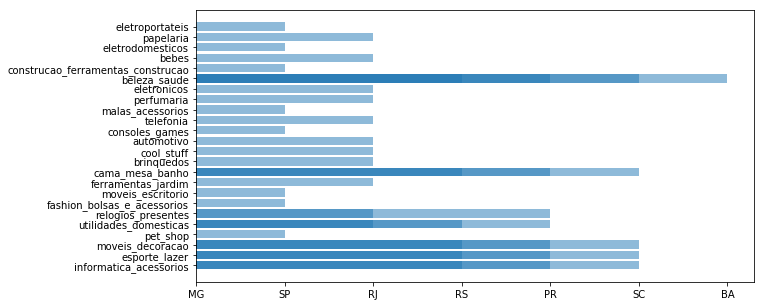

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
plt.barh(mais50['product_category_name'],mais50['customer_state'], alpha=0.5)
plt.show()

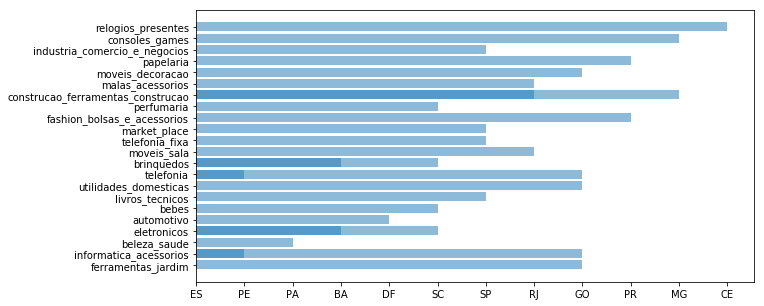

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
plt.barh(menos50['product_category_name'],menos50['customer_state'], alpha=0.5)
plt.show()

Nuvem de palavras geral

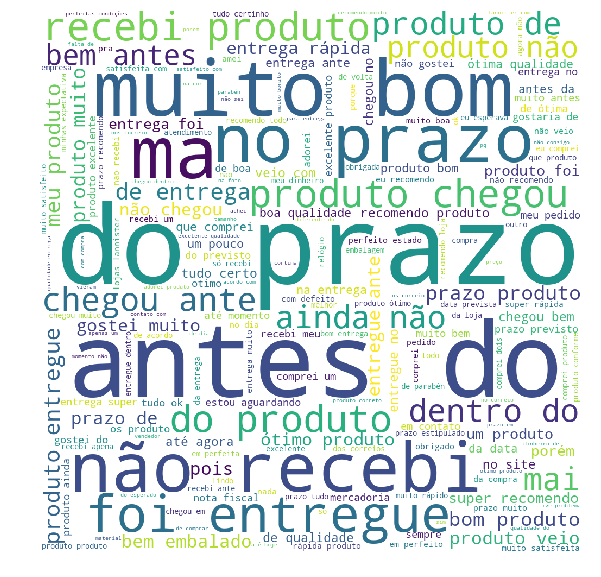

In [10]:
comment_words = '' 
order_review = order_review.dropna(subset=['review_comment_message'])
for val in order_review['review_comment_message']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

In [11]:
seller_items = order_items.merge(vendedores,on='seller_id')
seller_orders = seller_items.merge(orders,on='order_id')
seller_orders_customers = seller_orders.merge(customers,on='customer_id')
vend_pay_reviews = seller_orders_customers.merge(order_review,on='order_id')
vend_pay_reviews = vend_pay_reviews.merge(produtos, on='product_id')

In [12]:
promotores = vend_pay_reviews.loc[vend_pay_reviews['review_score']>=4]
detratores = vend_pay_reviews.loc[vend_pay_reviews['review_score']<=2]
detratores = detratores.dropna(subset=['review_comment_message'])
promotores = promotores.dropna(subset=['review_comment_message'])

detratores['review_comment_message'] = detratores['review_comment_message'].astype(str)
detratores['review_comment_message'] = detratores['review_comment_message'].str.lower().str.split()

detratores['review_comment_message'] = detratores['review_comment_message'].apply(lambda x: ' '.join([item for item in x if item not in stop]))

promotores['review_comment_message'] = promotores['review_comment_message'].astype(str)
promotores['review_comment_message'] = promotores['review_comment_message'].str.lower().str.split()

promotores['review_comment_message'] = promotores['review_comment_message'].apply(lambda x: ' '.join([item for item in x if item not in stop]))

Detratores

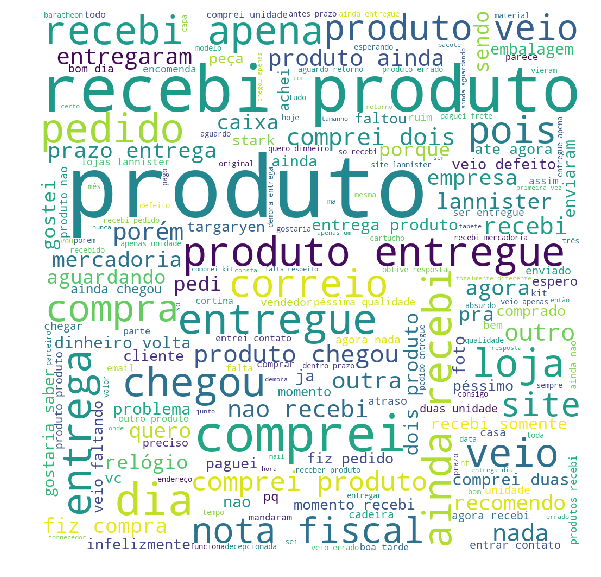

In [13]:
comment_words = '' 
for val in detratores['review_comment_message']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

Promotores

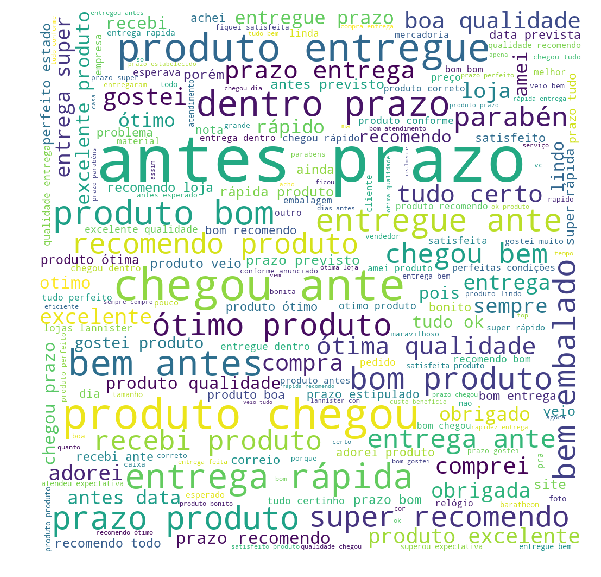

In [14]:
comment_words = '' 
for val in promotores['review_comment_message']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [15]:
detratores_estados = detratores.groupby('customer_state').agg({'customer_unique_id':'count'}).reset_index()
promotores_estados = promotores.groupby('customer_state').agg({'customer_unique_id':'count'}).reset_index()

In [16]:
Bra_in_satisfacao = folium.Map(location=[-16.1237611, -59.9219642],
    zoom_start=6)

In [17]:
detratores_estados = pd.merge(detratores_estados,uf_lat_log.rename(columns={'uf':'customer_state'}), on='customer_state')
promotores_estados = pd.merge(promotores_estados,uf_lat_log.rename(columns={'uf':'customer_state'}), on='customer_state')


In [18]:
top_15_detratores = detratores_estados.sort_values(['customer_unique_id'], ascending=False).head(15)
top_15_promotores = promotores_estados.sort_values(['customer_unique_id'], ascending=False).head(15)

In [19]:
for x, y in top_15_detratores.iterrows():
    folium.Marker(
        location=[y['latitude'],y['longitude']],
        popup=f"{y['customer_unique_id']},{y['customer_state']}",
        
    ).add_to(Bra_in_satisfacao)

Bra_in_satisfacao


In [20]:
for x, y in top_15_promotores.iterrows():
    folium.Marker(
        location=[y['latitude'],y['longitude']],
        popup=f"{y['customer_unique_id']},{y['customer_state']}",
        icon=folium.Icon(color='pink')
    ).add_to(Bra_in_satisfacao)

Bra_in_satisfacaofig, ax = plt.subplots(figsize=(10,5))

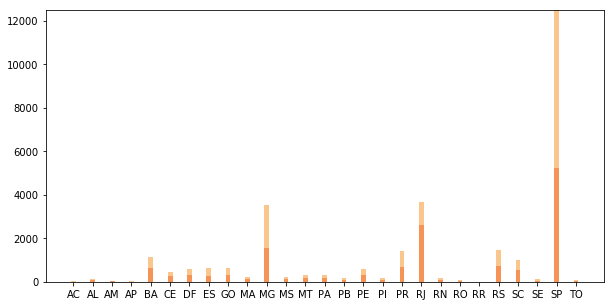

In [53]:
pos = list(detratores_estados['customer_state'])
width = 0.25 
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, 
        detratores_estados['customer_unique_id'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        ) 

plt.bar(pos, 
        promotores_estados['customer_unique_id'],
        width, 
        alpha=0.5, 
        color='#F78F1E', 
       ) 

plt.ylim([0, max(promotores_estados['customer_unique_id'])])
plt.show()

Mesmos estados que não estão sendo tão expressivos em compras, em comparação com outros estados principalmente do Sul-Sudeste, onde é a concentração dos clientes, ainda são os que agem como promotores e podem com campanhas corretas viabilizar uma crescente de consumo através da plataforma. 

Chama também atenção sobre como o Estado do Maranhão, está entre um dos 15 estados com mais detratores, e não esta entre um dos 15 com mais promotores, levando assim a ligar um botão vermelho em relação ao tratamento dado a experiência do cliente nessa região


Pelas nuvens de palavras, fica também claro que o encantamento vem pelas entregas rápidas, principalmente quando são antes do prazo previsto, como também a decepção vem pelo mesmo motivo.